In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Use automap_base() to reflect the tables into classes
Base = automap_base()

# Reflect the tables from the database into the Base
Base.prepare(engine, reflect=True)


# reflect the tables
#Save references to the 'station' and 'measurement' classes
Station = Base.classes.station
Measurement = Base.classes.measurement




In [9]:
# View all of the classes that automap found
# List all the classes found by automap
for table_name, table_class in Base.classes.items():
    print(f"Table Name: {table_name}, Class Name: {table_class.__name__}")


Table Name: measurement, Class Name: measurement
Table Name: station, Class Name: station


In [12]:
# Save references to each table
# Create a dictionary to store references to all the reflected classes
reflected_classes = {}

# Iterate through the reflected classes and save references
for table_name, table_class in Base.classes.items():
    reflected_classes[table_name] = table_class




sqlalchemy.ext.automap.station

In [23]:
## Viewing tables in the data base
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('Resources/hawaii.sqlite')

# Create a cursor object
cursor = conn.cursor()

# Execute an SQL query to view the tables
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])

# Close the cursor and connection
cursor.close()
conn.close()

Tables in the database:
measurement
station


In [28]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [29]:
# Find the most recent date in the data set.


# Define an SQL query to retrieve the most recent date
query = text("SELECT date FROM measurement ORDER BY date DESC LIMIT 1")

# Execute the query a
result = session.execute(query)
most_recent_date = result.scalar()

# Close the database connection
#session.close()

# 'most_recent_date' now contains the most recent date in the dataset
print("Most Recent Date:", most_recent_date)



Most Recent Date: 2017-08-23


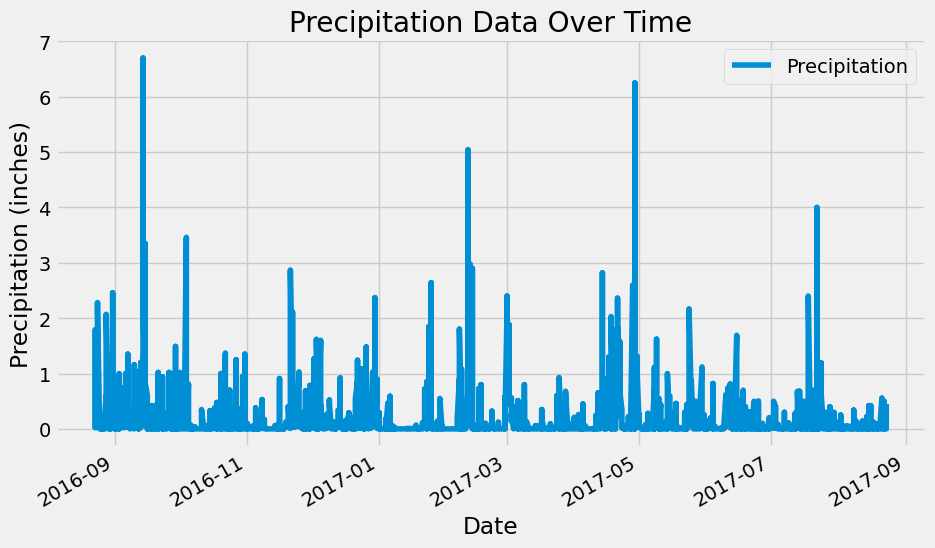

In [50]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
from datetime import datetime, timedelta

# Starting from the most recent data point in the database. 
most_recent_date_query = text("SELECT MAX(date) FROM measurement")
most_recent_date = session.execute(most_recent_date_query).scalar()

# Calculate the date one year from the last date in data set.
twelve_months_ago = (datetime.strptime(most_recent_date, "%Y-%m-%d") - timedelta(days=365)).strftime("%Y-%m-%d")
#print(twelve_months_ago)


# Perform a query to retrieve the data and precipitation scores
query = text("SELECT date, prcp FROM measurement WHERE date >= :start_date")
query = query.bindparams(start_date=twelve_months_ago)
result = session.execute(query)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
column_names = ["Date", "Precipitation"]
precipitation_data = pd.DataFrame(result.fetchall(), columns=column_names)

# Sort the dataframe by date
precipitation_data.sort_values(by='Date', inplace=True)
# Remove rows with NaN values in the 'Precipitation' column
precipitation_data.dropna(subset=['Precipitation'], inplace=True)
precipitation_data


# Use Pandas Plotting with Matplotlib to plot the data
# Convert the 'Date' column to a datetime type
precipitation_data['Date'] = pd.to_datetime(precipitation_data['Date'])

# Set the 'Date' column as the DataFrame's index
precipitation_data.set_index('Date', inplace=True)

# Create a line plot of the precipitation data
precipitation_data.plot(y='Precipitation', figsize=(10, 6))

# Customize the plot (labels, title, etc.) if needed
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Precipitation Data Over Time')
plt.legend(['Precipitation'])

# Show the plot
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_data['Precipitation'].describe()

# Convert the result into a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Reset the index to have a proper DataFrame structure
summary_stats_df.reset_index(inplace=True)

# Rename the columns for clarity
summary_stats_df.columns = ['Statistic', 'Precipitation']

# Display the DataFrame with summary statistics
summary_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [56]:
# Design a query to calculate the total number of stations in the dataset
# Define an SQL query to count the total number of stations
query = text("SELECT COUNT(DISTINCT station) as total_stations FROM station")

# Execute the query and fetch the result
result = session.execute(query)
total_stations = result.scalar()
print("Total Number of Stations:", total_stations)


Total Number of Stations: 9


In [65]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = text("""
    SELECT station, COUNT(station) AS station_count
    FROM station
    GROUP BY station
    ORDER BY station_count DESC
""")

# Execute the query and fetch the result
result = session.execute(query)
most_active_stations = result.fetchall()

# The first row in the result will be the most active station
print("Most Active Stations (in descending order):")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")


Most Active Stations (in descending order):
Station: USC00519523, Count: 1
Station: USC00519397, Count: 1
Station: USC00519281, Count: 1
Station: USC00518838, Count: 1
Station: USC00517948, Count: 1
Station: USC00516128, Count: 1
Station: USC00514830, Count: 1
Station: USC00513117, Count: 1
Station: USC00511918, Count: 1


In [73]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

# Define the station ID for the most active station
most_active_station_id = 'USC00519523'  # Replace with the actual station ID

query = text("""
    SELECT MIN(tobs) AS min_temperature, 
           MAX(tobs) AS max_temperature, 
           AVG(tobs) AS avg_temperature
    FROM measurement
    WHERE station = :most_active_station
""")

query = query.bindparams(most_active_station=most_active_station_id)

result = session.execute(query)
temperature_summary = result.fetchone()

# # # Access the values as needed
min_temperature = temperature_summary.min_temperature
max_temperature = temperature_summary.max_temperature
avg_temperature = temperature_summary.avg_temperature

print(f"Most Active Station (ID: {most_active_station_id})")
print(f"Lowest Temperature: {min_temperature} °F")
print(f"Highest Temperature: {max_temperature} °F")
print(f"Average Temperature: {avg_temperature} °F")


Most Active Station (ID: USC00519523)
Lowest Temperature: 56.0 °F
Highest Temperature: 85.0 °F
Average Temperature: 74.5436493068565 °F


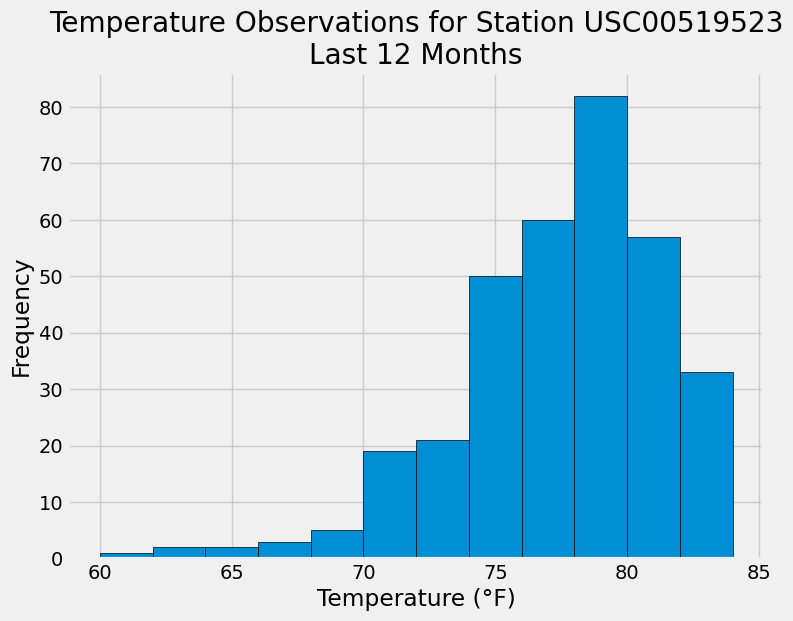

In [97]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# Convert the most recent date string to a datetime object
most_recent_date_1 = datetime.strptime(most_recent_date, '%Y-%m-%d')
end_date = most_recent_date_1

start_date = end_date - timedelta(days=365)
most_active_station_id = 'USC00519523'  # Replace with the actual station ID

# Define an SQL query to retrieve the temperature observations for the most active station
temperature_query = text("""
    SELECT tobs
    FROM measurement
    WHERE station = :station_id
    AND date >= :start_date
    AND date <= :end_date
""")

# # Bind parameters to the query using query.bindparams()
temperature_query = temperature_query.bindparams(station_id=most_active_station_id, start_date=start_date, end_date=end_date)

# Execute the query
temperature_result = session.execute(temperature_query)

# Fetch the temperature data into a list
temperature_data = [row.tobs for row in temperature_result]

# Remove zero or missing values from the data
#temperature_data = [temp for temp in temperature_data if temp is not None and temp != 0]


# Create a histogram plot of the temperature data
bin_edges = range(60, 86, 2)  # Adjust bin edges as needed
plt.figure(figsize=(8, 6))
plt.hist(temperature_data, bins=bin_edges, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station_id}\nLast 12 Months')
plt.show()



# Close Session

In [98]:
# Close Session
session.close()